# Введение в глубокое обучение

## Занятие 4. Компьютерное зрение. Сверточные нейросети.

План занятия: 

1. Почему полносвязные сети плохо подходят для работы с изображениями
2. Операция свертки
3. Устройство сверточной нейросети
4. Построение сверточной сети в PyTorch для решения задачи классификации картинок 

## Теория

### Полносвязная сеть для работы с изображениями. 

Прежде чем изучать устройство сверточных нейросетей, давайте поговорим о том, зачем они вообще нужны. 

Мы уже изучили то, как устроены полносвязные нейросети. Почему бы не использовать их для обработки изображений? Зачем нужно изобретать какой-то новый вид нейросетей?

Ответ: потому что **полносвязные нейросети очень неэффективны для обработки изображений**. Давайте обсудим, почему.

Для начала, заметим, что обучить полносвязную нейросеть обрабатывать картинки все же возможно. 


#### MNIST

Рассмотрим задачу классификации изображений из датасета MNIST. MNIST — датасет черно-белых изображений рукописных цифр от 0 до 9: всего 10 классов. Изображения в датасете имеют размер 28х28 пикселей. 

На этом датасете можно решать задачу классификации изображений на 10 классов.

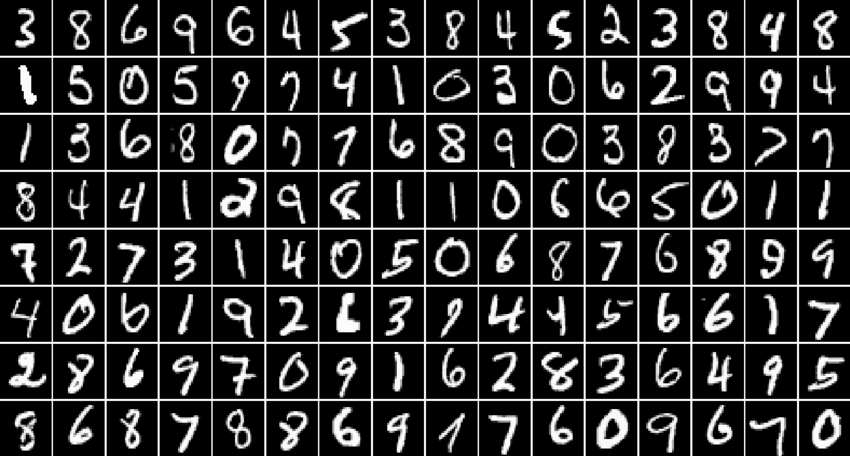

Чтобы решить задачу классификации картинок MNIST с помощью нейросетей, нужно научиться подавать картинку сети на вход. Полносвязная нейросеть принимает на вход данные, представленные в виде вектора чисел. Если у нейросети в первом слое N нейронов, то входящий вектор чисел должен быть размера N. 

Черно-белая картинка из датасета MNIST представляет собой двумерную матрицу чисел. Числа матрицы отражают яркость соответствующего пикселя картинки:


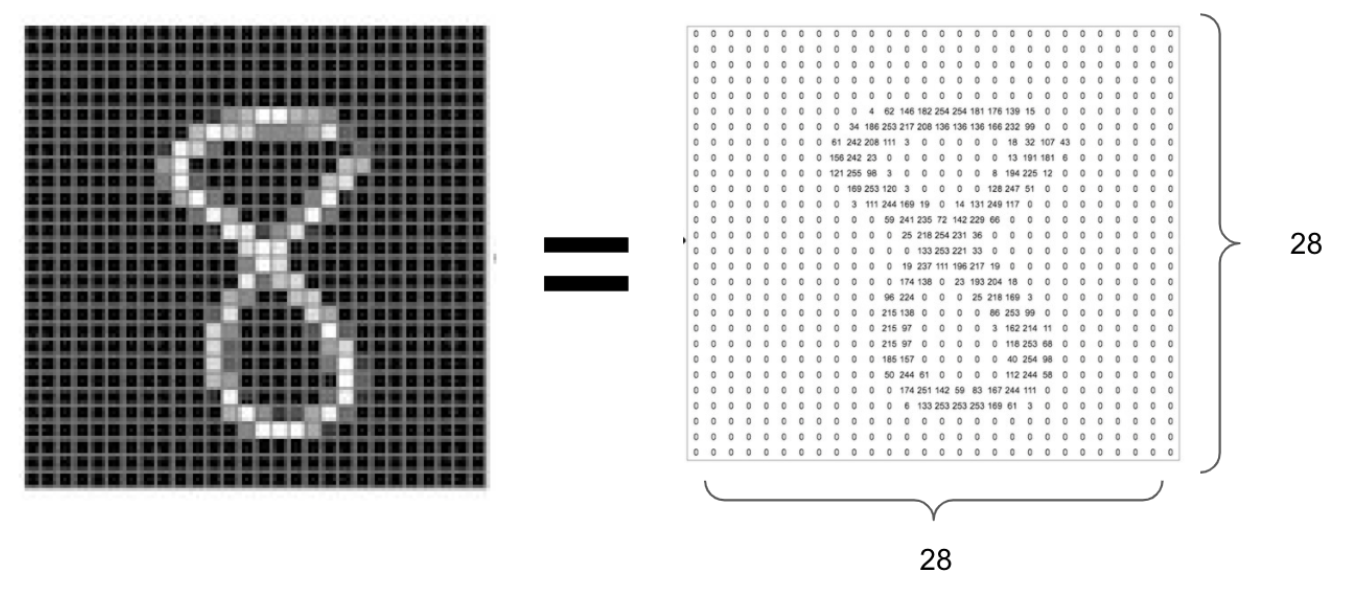

In [1]:
from PIL import Image

In [32]:
img = Image.open('8.png')
img

In [ ]:
import numpy as np
np.array(img)

Чтобы подать картинку на вход нейросети, нужно эту матрицу растянуть в вектор (на английском эта операция "растягивания" матрицы в вектор называется flatten; мы к ней еще вернемся позже). Сделать это можно, например, так: склеить все строки матрицы в один длинный вектор. Тогда из матрицы размера 28х28 получится вектор длины 784. Значит, первый слой нейросети, которая будет принимать на вход такой вектор, должен будет содержать 784 нейрона. Подавая таким способом изображения на вход полносвязный нейросети, мы можем обучить нейросеть решать задачу классификации картинок MNIST.

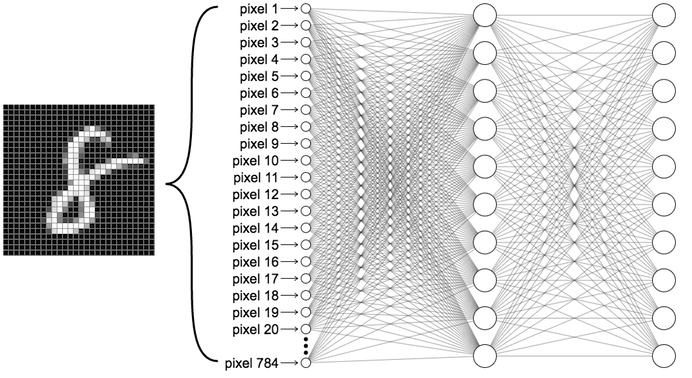

**У такого подхода к построению сети для обработки изображений есть недостатки**. 
Вот какие:

1. При таком подходе в первом слое нейросети получается очень много нейронов, и, соответственно, обучаемых параметров (весов). Такая нейросеть легко переобучится. 

2. Второй недостаток: полносвязная нейросеть обрабатывает разные части картинки по-разному, даже если на них расположены одинаковые объекты.


3. Обычно объекты на изображениях расположены компактно: например, на картинке ниже все пиксели, относящиеся к собаке, расположены в небольшой области в левом верхнем углу картинки. Это принцип локальности (locality) объектов. И чтобы найти нужный объект на картинке, нужно сконцентрировать взгляд на локальных частях картинки, а не смотреть сразу на все изображение целиком. Полносвязная же нейросеть "смотрит" на всю картинку целиком: каждый ее слой обрабатывает абсолютно все пиксели исходной картинки. 




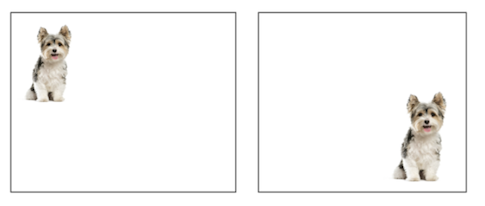

Это недостатки полносвязной нейросети для работы с изображениями. На практике полносвязные сети для картинок не используют. **Сверточные нейросети же устроены таким образом, что механизм их работы позволяет обрабатывать картинки очень эффективно**. У них нет недостатков, описанных выше.

Сейчас мы узнаем, как устроены и работают сверточные нейросети. 

### Идея работы сверточной нейросети

Посмотрите на две картинки из датасета MNIST. Что отличает картинку четверки от картинки восьмерки?


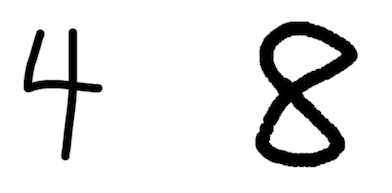

#### Ответ: Что отличает четверку от восьмерки

Один из ответов на этот вопрос может быть таким: четверка преимущественно состоит из вертикальных и горизонтальных линий, а восьмерка — из изогнутых

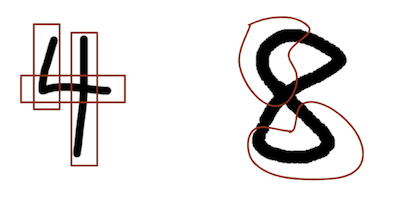

Сверточные нейросети основаны на похожей идее обработки изображений: они выделяют из картинок информацию о наличии либо отсутствии на картинке неких форм, паттернов (вертикальные/изогнутые линии — это примеры простых паттернов), и на основе этой информации получают итоговый ответ.

Чтобы узнать, как устроена сверточная нейросеть, нужно сначала изучить операцию свертки.

### Операция свертки.

Операция свертки состоит в сворачивании изображения с помощью фильтра. **Фильтр** (или, другое название, ядро; англ kernel) — это тоже матрица чисел. 


Свертка изображения размера 4х4 фильтром размера 3х3:
Полученный результат называется **картой активации**.

Свертка картинки шаг за шагом: [слайды](https://docs.google.com/presentation/d/1tR-fNA65TrISMU7Iw7Pc9mJg8cvcmUti/edit?usp=sharing&ouid=113011837198348805491&rtpof=true&sd=true)

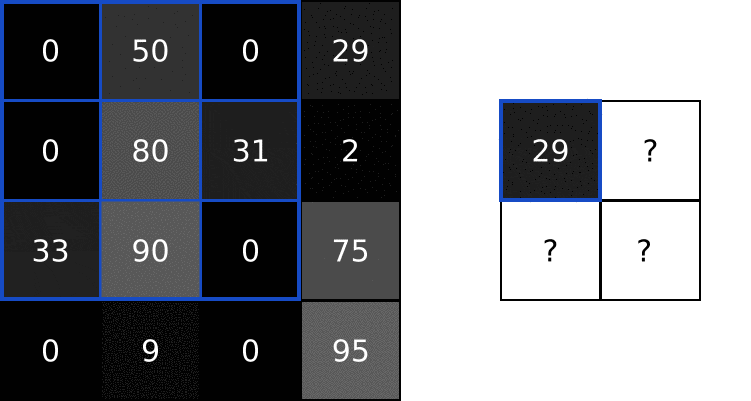

Заметим, что размер карты активации после свертки стал меньше, чем размер изначального изображения. Общая формула размера карты активаии такая: 

$$m = i - f + 1,$$

где: 
- m — размер карты активации;
- i — размер изображения;
- f — размер фильтра. 


#### Свертка RGB-картинок

Сворачивать цветные картинки тоже очень просто. Есть два варианта:

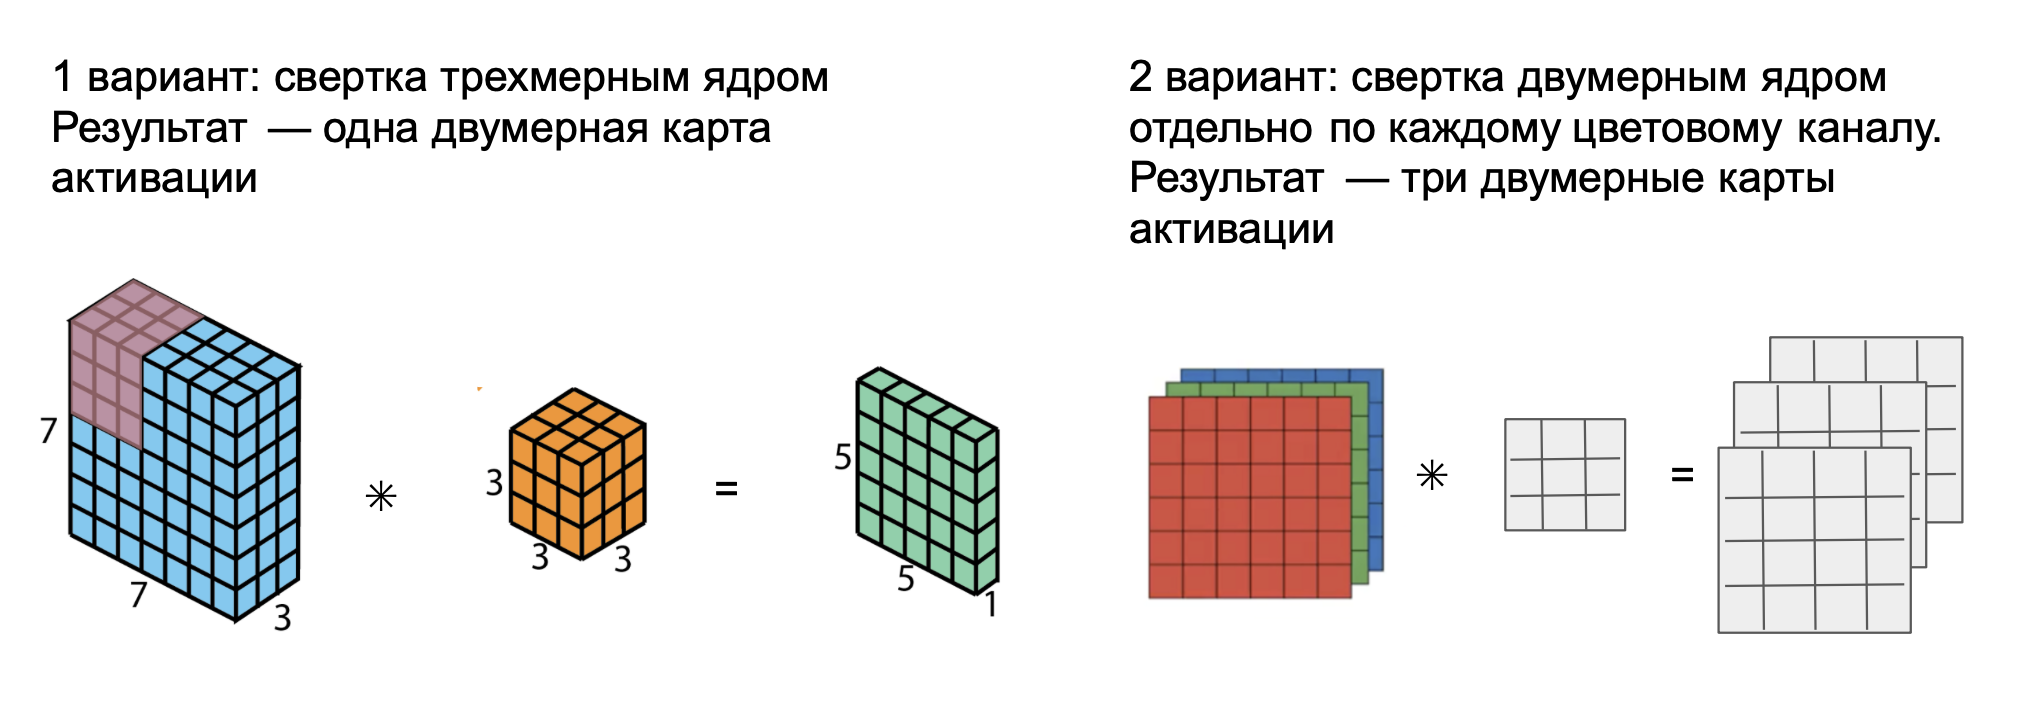

Чаще всего используется первый вариант: трехмерные фильтры.

#### Смысл операции свертки

Рассмотрим свертку одной картинки домика двумя фильтрами. Эти фильтры имеют названия: "вертикальный фильтр Собеля" и "горизонтальный фильтр Собеля":

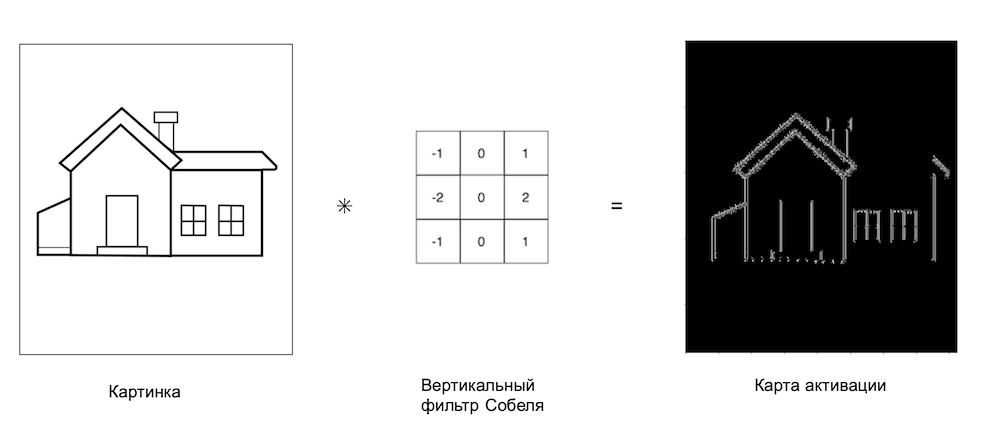

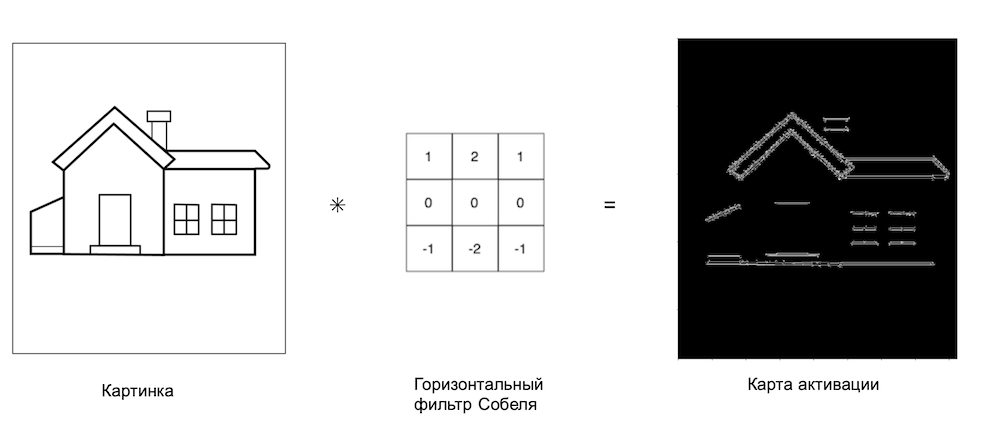

Видно, что на полученных картах активации подсвечены места, в которых на исходном изображении находились вертикальные линии (в первом случае) и горизонтальные линии (во втором случае). "Подсвечены" означает, что на карте активации в этих местах находятся большие по модулю числа — чем больше значение пикселя, тем ярче, белее цвет этого пикселя. 

Таким образом, вертикальный фильтр Собеля выделяет из изображения информацию, в каких местах изображения присутствуют вертикальные линии. А горизонтальный фильтр Собеля выделяет из изображения информацию, в каких местах изображения присутствуют горизонтальные линии.


Тут становится понятно, почему карта активации так называется: на ней "активированы" места, в которых на изначальном изображении присутствует некоторый паттерн, который "ищет" фильтр. Фильтр, проходя по изображению, "активируется" в местах, в которых на изображении есть определенные паттерны, и в этих местах на карте активации появляются большие числа (белые пиксели — это большие числа в матрице изображения, черные — маленькие).


Собственно, **общая идея работы сверточной нейросети** для задачи классификации такая: с помощью фильтров выделить из изображения информацию о паттернах, которые присутствуют на изображении, и передать эту информацию на вход полносвязной нейросети. Она уже по этой информации поймет, что за объект изображен на картинке.


In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

def sobel_filter(img, k_size, mode='vertical'):

    img_filtered = img.astype(np.float)

    width, height, c = img.shape
    if c > 1:
        img = 0.2126 * img[:,:,0] + 0.7152 * img[:,:,1] + 0.0722 * img[:,:,2]

    assert(k_size == 3 or k_size == 5);

    if k_size == 3:
        kh = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
        kv = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype = np.float)
    else:
        kh = np.array([[-1, -2, 0, 2, 1], 
                   [-4, -8, 0, 8, 4], 
                   [-6, -12, 0, 12, 6],
                   [-4, -8, 0, 8, 4],
                   [-1, -2, 0, 2, 1]], dtype = np.float)
        kv = np.array([[1, 4, 6, 4, 1], 
                   [2, 8, 12, 8, 2],
                   [0, 0, 0, 0, 0], 
                   [-2, -8, -12, -8, -2],
                   [-1, -4, -6, -4, -1]], dtype = np.float)

    gx = signal.convolve2d(img, kh, mode='same', boundary = 'symm', fillvalue=0)
    gy = signal.convolve2d(img, kv, mode='same', boundary = 'symm', fillvalue=0)

    if mode == 'vertical':
        g = np.sqrt(gx * gx)
    elif mode == "horizontal":
        g = np.sqrt(gy * gy)
    else:
        raise ValueError('unknown mode')

    g *= 255.0 / np.max(g)   

    return g

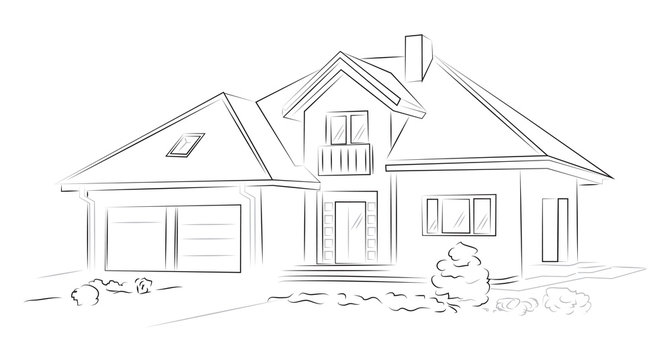

In [3]:
from PIL import Image 

img = Image.open('sketch.jpg')
img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarnin

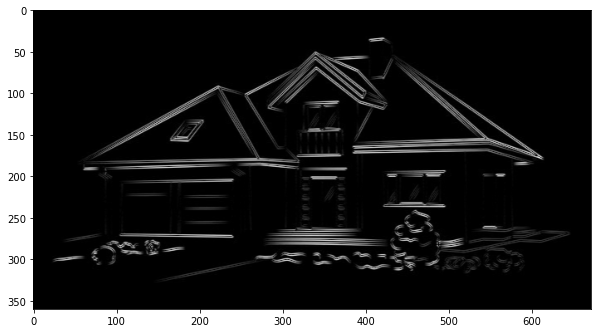

In [7]:
img_filtered = sobel_filter(np.array(img), 3, mode='horizontal')

plt.figure(figsize=(10, 8))
plt.imshow(img_filtered, cmap='gray')

### Прототип сверточной сети для классификации четверок и восьмерок

Давайте представим, как могла бы выглядеть сверточная сеть для классификации картинок четверок и восьмерок:

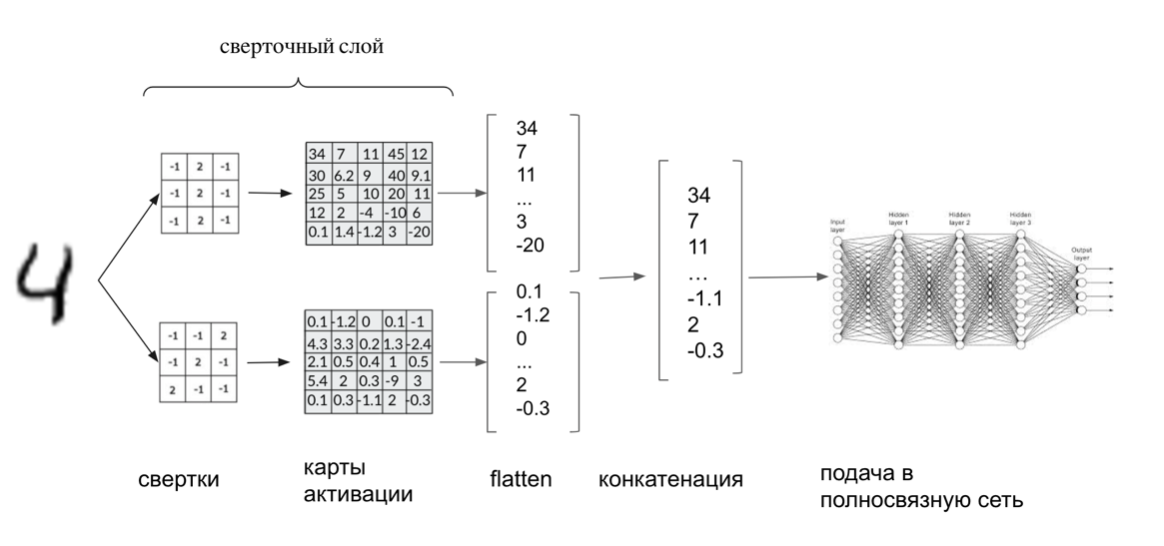

**Как картинки обрабатываются такой сетью:**

1. Картинка сворачивается с помощью двух фильтров, получаются две карты активации;
2. Каждая карта активации растягивается в вектор: точно так же, как мы в начале статьи растягивали картинку в вектор для подачи на вход полносвязной сети. Эта операция "растягивания" называется flatten;
3. Полученные два вектора конкатенируются, получается один вектор в два раза большей длины;
4. Полученный в 3 пункте вектор подается на вход полносвязный сети, которая выдает ответ на задачу классификации: к какому классу принадлежит картинка.


В этом заложен следующий смысл: два фильтра выделяют из картинки информацию о том, есть ли на входящей картинке вертикальные и диагональные линии. На картах активаций будут присутствовать большие по модулю числа, если на картинке есть вертикальные или диагональные линии соответственно. Если мы подадим на вход картинку четверки, то на первой карте активации будут присутствовать большие числа, а на второй — нет. А если подадим на вход картинку восьмерки, то будет наоборот: второй фильтр "активирует" карту активации, первый — нет. В итоге после операции flatten и конкатенации полученные векторы для картинки четверки и картинки восьмерки будут отличаться: в векторе, соответствующем четверке, будут большие числа наверху и маленькие — внизу, а в векторе, соответствующем восьмерке — наоборот. Этот вектор мы подаем на вход полносвязный сети, которая по вектору должна выдать ответ: к какому классу принадлежит входная картинка. Эту полносвязную сеть мы легко можем обучить на эту задачу с помощью обычного backpropagation. Таким образом вся наша модель отлично обучится классифицировать картинки четверок и восьмерок.


### Сверточная нейросеть

Чтобы из нашего прототипа получить настоящую сверточную нейросеть, осталось два небольших шага. 

#### Фильтр — обучаемый параметр

В примере выше мы зафиксировали фильтры нашей модели и обучали только полносвязную сеть, которая принимает карты активации на вход. Но мы можем (и в реальных нейросетях так и есть) обучать и фильтры тоже. 
Обучение фильтров сверточных слоев имеет смысл. При построении сверточной нейросети не всегда можно сразу понять, какие фильтры подойдут для решения конкретной задачи. 

Попробуйте, например, понять, какие фильтры подойдут для решения задачи классификации кошек и собак?

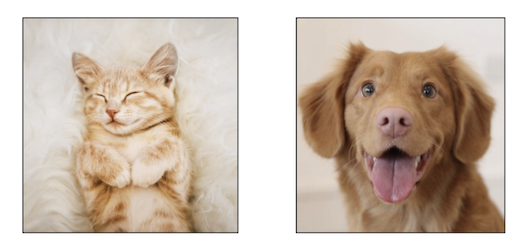

Поэтому отличная идея —  **дать нейросети в процессе обучения самой понять, какие фильтры лучше всего подходят для решения той или иной задачи** — то есть сделать веса фильтров обучаемыми параметрами.

Таким образом, обучаемыми параметрами сверточной нейросети являются все веса всех фильтров (веса — числа в матрице фильтра) и веса полносвязной части сети. 
Обучается сверточная нейросеть с помощью знакомого нам алгоритма backpropagation. Для обучения весов сверточных слоев ничего дополнительно изобретать не нужно.

#### Несколько слоев сверток

Выше мы рассматривали задачу классификации картинок четверок и восьмерок.  Это очень простая задача, и, на самом деле, тут даже свертки не нужны. С этим справилась бы обычная полносвязная нейросеть. Задачи, которые встречаются в реальном мире, гораздо сложнее.
Пример — задача классификации картинок ImageNet. Чтобы решить задачу классификации картинок ImageNet на 1000 классов, одного слоя свертки с двумя фильтрами, как мы делали выше, будет недостаточно. Один слой может выделить информацию о том, какие и где на изображении есть простые линии: вертикальные, диагональные или какие-либо другие. Но этой информации недостаточно, чтобы передать ее в полносвязную сеть и точно классифицировать это изображение в один из тысячи классов. Хочется уметь выделять из картинки более сложную информацию, например, наличие сложных составных элементов: кузова и колес машины, ручки стакана, глаз, носа и лица в целом.

Это решается тем, что в сверточную нейросеть добавляется несколько слоев сверток.

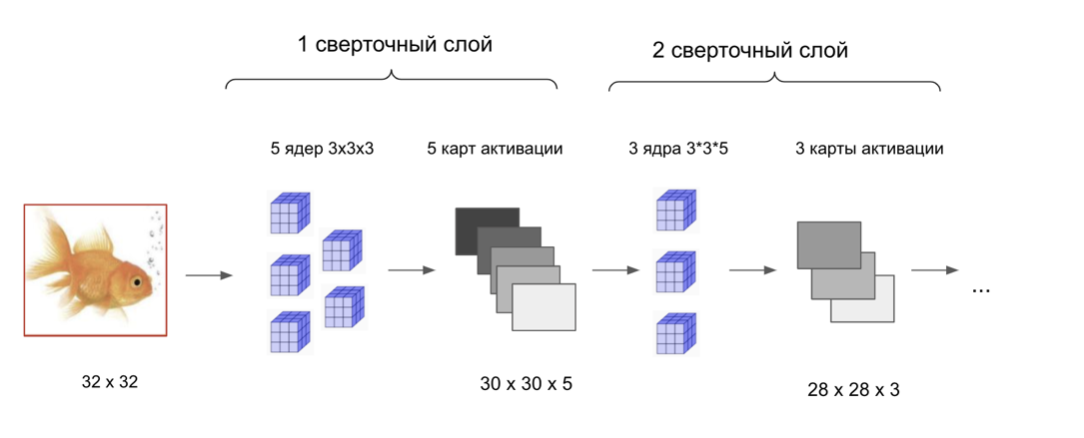

**Принцип работы сверточной нейросети**:

- Первый сверточный слой. Сворачиваем входящую картинку несколькими (например, пятью) фильтрами, получаем пять карт активаций. Так как входная картинка цветная, т.е. представлена трехмерной матрицей, то фильтры — также трехмерные матрицы. Пусть они будут размера 4х4х3. Полученные карты активации после свертки такими фильтрами — двумерные.
- Второй сверточный слой. Им мы сворачиваем карты активации, которые получились на выходе предыдущего слоя. Пять двумерных карт активаций можно представить как одну трехмерную матрицу, у которой третья размерность — 5. Это как будто картинка, у которой не 3 цветовых канала, а 5. Такую трехмерную матрицу можно свернуть трехмерными свертками, у которых третья размерность — тоже 5. Пусть это будут три свертки размерности 3х3х5. На выходе этого слоя получим 3 двумерные карты активации.
- Далее можно добавлять еще слои сверток с разным количеством и размерами фильтров. После последнего слоя свертки нужно растянуть все карты активации последнего слоя в векторы (flatten), конкатенировать их и подать на вход полносвязной части сети, как мы делали выше. В итоге схематично устройство сверточной сети можно проиллюстрировать так:



В итоге схематично сверточная нейросеть выглядит так:

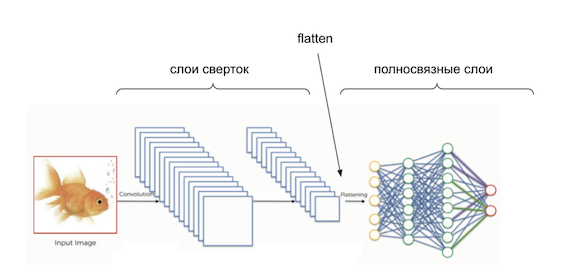

**Какой смысл в нескольких слоях сверток?** Дело в том, что каждый последующий слой сверток сворачивает карты активации, выданные предыдущим слоем. И в обученной нейросети получается так, что каждый следующий слой сверток реагирует на более высокоуровневую и сложную информацию, которая присутствует на входном изображении.

Первый слой выделяет из изображения информацию, где не изображении находятся простые линии: вертикальные, горизонтальные, диагональные, etc. 
Каждый последующий слой сверток реагирует на более высокоуровневые паттерны: части тела кота, рыбы, глаза, уши и т.д.


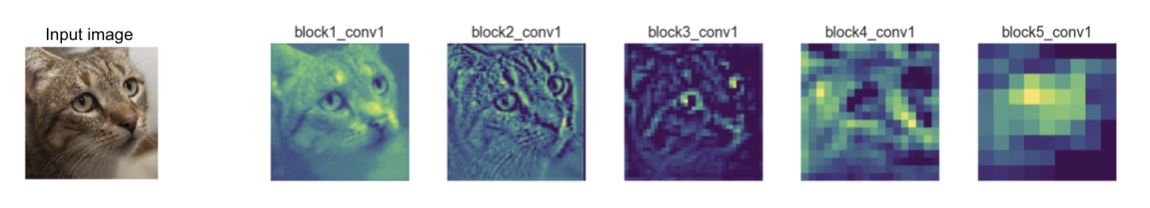

Таким образом, наши сверточные слои как бы обрабатывают картинку, распознавая на ней сначала низкоуровневые паттерны (горизонтальные/вертикальные/наклонные линии), а затем постепенно собирая эти паттерны вместе в более сложные конструкции, такие как глаза, уши, нос, и, в конце концов, в целую голову кошки.


**Подведем итог. Каким образом сверточные нейросети решают задачу классификации:**
- 
Сверточные слои выделяют из входного изображения наличие определенных паттернов, характерных для того или иного класса (наличие головы кота, собаки, хвоста самолета, кузова машины и т.д.). В нейросети активируются те фильтры, которые обучались реагировать на паттерны того типа, которые присутствуют на изображении.
- В итоге карты активации последнего слоя сети содержат информацию о том, какие из этих паттернов на входном изображении есть, а каких — нет. 
- Карты активации последнего слоя затем подаются на вход полносвязной части сети, которая по информации из карт определяет, какой именно объект изображен на входной картинке.


Заметим, что **сверточная нейросеть не имеет двух недостатков, что были у полносвязной нейросети:**

- фильтр применяется к локальным частям картинки;
- все части картинки обрабатываются одинаковыми фильтрами, т.е. одинаковыми механизмами.

### Пара последних нюансов

#### Функции активации в сверточных слоях

После всех сверточных слоев сети нужны функции активации. Чаще всего, как и в полносвязных сетях, для сверток используется функция активации ReLU. Функция активации действует поэлементно на каждый пиксель карты активации:


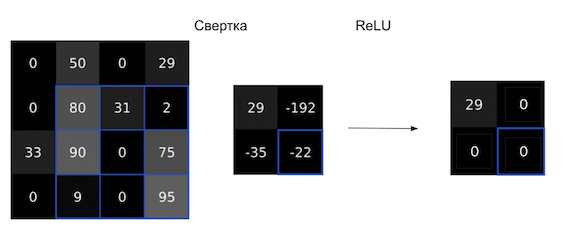

#### Pooling

Заметим, что наша первая проблема не решена: в сверточной нейросети все еще может быть много параметров. Рассмотрим, например, нейросеть с пятью сверточными слоями, которая обрабатывает картинки размера 100х100:

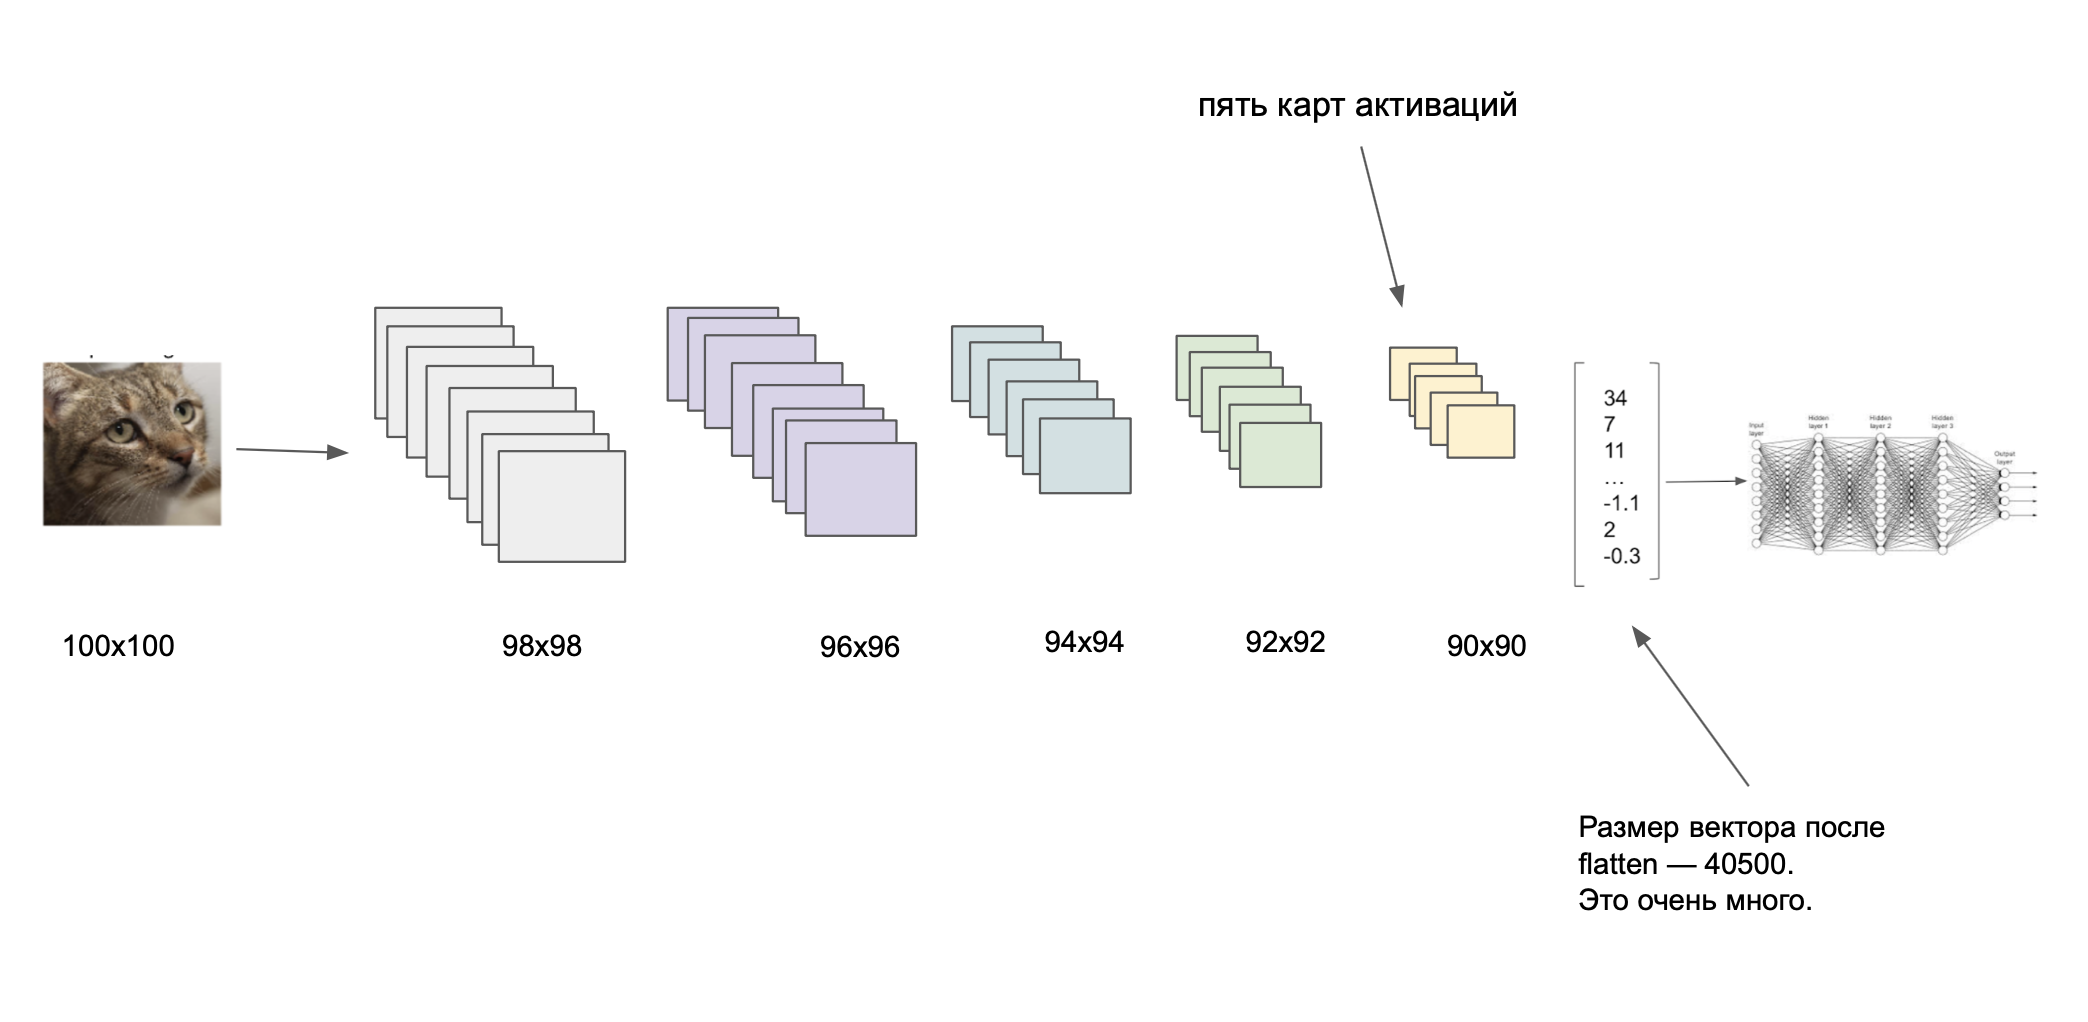

 Тогда размеры карт активаций последнего слоя будут девяносто на девяносто, и после операции flatten мы получим вектор размера девяносто на девяносто на пять, что равно сорок тысяч пятьсот. Получается, в первом слое полносвязной части должно быть сорок тысяч пятьсот нейронов, что жутко много. Сеть, конечно, переобучится.

**Решение: использовать Pooling**

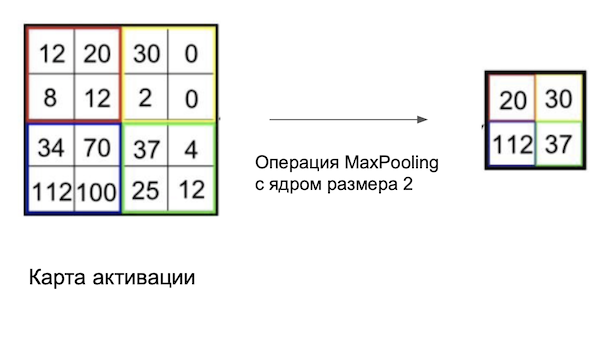

Как это помогает:

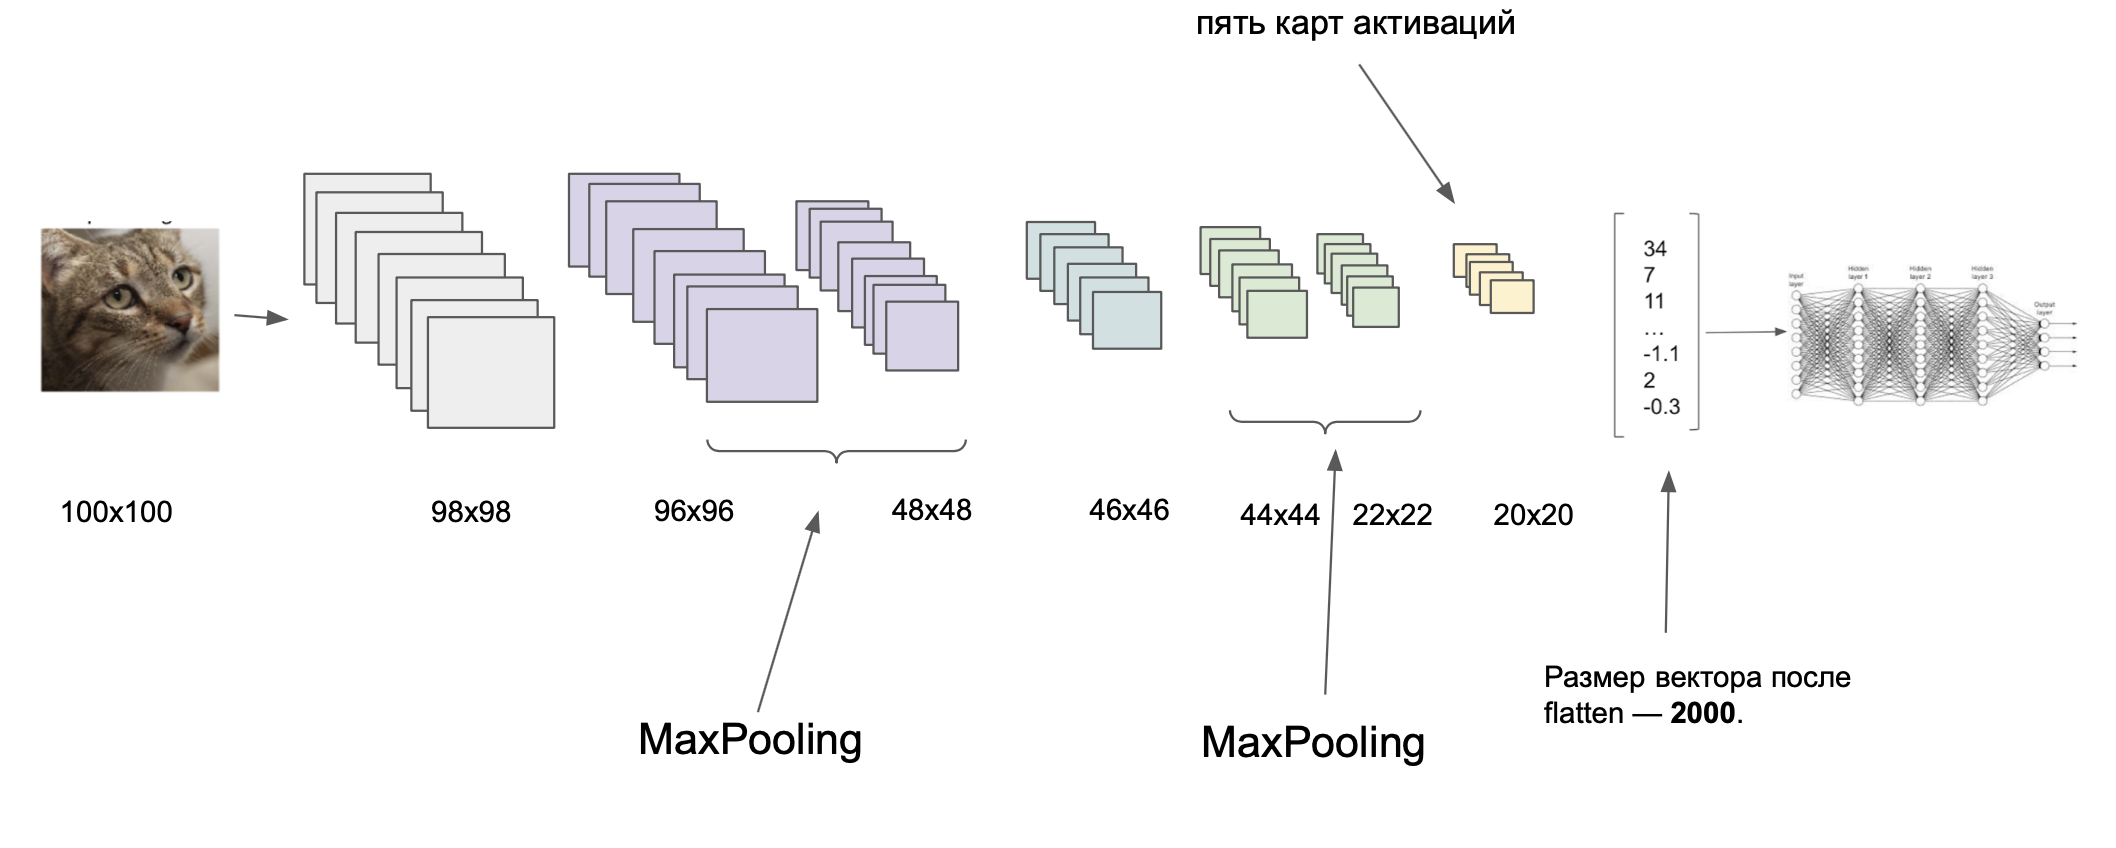

## Практика

На практике мы будем решать задачу классификации картинок CIFAR на 10 классов с помощью сверточных нейросетей. 


![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

### Загрузка датасета


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms

Датасет CIFAR — один из стандартных, поэтому он есть в модуле datasets библиотеки torchvision. И загрузить его очень просто:

In [3]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10_data
    Split: Train
    StandardTransform
Transform: ToTensor()

Поделим train_data на тренировочную и валидационную выборку:

In [5]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Заведем DataLoader'ы для каждой части датасета:

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Посмотрим на несколько картинок:

In [7]:
for batch in train_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [8]:
images.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [9]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

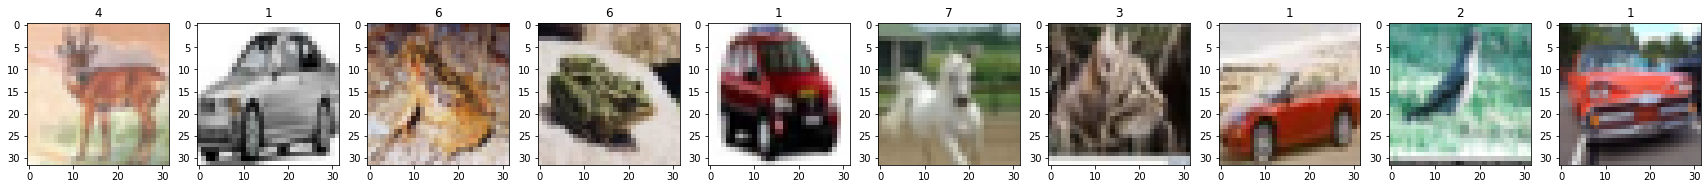

In [10]:
show_images(images, labels)

Таблица соответствий номеров ответов и классов:

| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      | 
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


### Определение класса сверточной нейросети

In [12]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F
# метрика качества 
from sklearn.metrics import accuracy_score

Объявим сверточную нейросеть.

Наша нейронная сеть будет сожержать четыре слоя: два сверточных и два полносвязных. Также после первого сверточного слоя добавим pooling. В качестве функции активации для внутренних слоев будем использовать ReLU.

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # размер исходной картинки 32х32

        # conv 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3)) #30x30
        # pool
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #15x15
        # conv 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) #13x13
        
        # flatten
        self.flatten = nn.Flatten()

        # linear 1
        self.fc1 = nn.Linear(13 * 13 * 9, 128)
        # linear 2
        self.fc2 = nn.Linear(128, 10)

    
    def forward(self, x):
        # x [64, 3, 32, 32]
        # forward pass сети

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [14]:
# объявляем сеть
conv_net = ConvNet()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
conv_net = conv_net.to(device)

### Обучение нейросети

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

Импортируем библиотеки и напишем нужные команды для загрузки Tensorboard. Это утилита, которая позволяет автоматически строить и мониторить графики в процессе обучения нейросети. 

Заведем папку для хранения файлов с информацией о том, как обучается нейросеть:

In [ ]:
import os

# этот код создает папку на диске с названием 'logs'
if not os.path.exists('logs'):
    os.mkdir('logs')

Загрузим расширение Tensorboard:

In [64]:
%load_ext tensorboard

Заведем SummaryWriter: это объект, который во время обучения нейросети будет записывать в файлы информацию о том, какой у нейросети текущий лосс/accurcay:

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

Загружаем Tensorboard. Прямо у ноутбуке будут выводиться графики обучения сети.

In [ ]:
%tensorboard --logdir=./logs

Напишем функцию обучения сети:

In [ ]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = len(dataloader)

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        with torch.no_grad():
            logits = model(X_batch)
            
            loss = loss_fn(logits, y_batch)
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy, np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    num_iter = 0
    
    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch)

        model.train(True)
        
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch 
            
            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch) 
            
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch) 
            
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            #########################
            # Логирование результатов
            num_iter += 1
            writer.add_scalar('Loss/train', loss.item(), num_iter)

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers) / len(y_batch)
            writer.add_scalar('Accuracy/train', train_accuracy, num_iter)
            #########################

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)

        writer.add_scalar('Loss/val', val_loss.item(), num_iter)
        writer.add_scalar('Accuracy/val', val_accuracy, num_iter)
        
        
    return model

In [ ]:
conv_net = train(conv_net, loss_fn, optimizer, n_epoch=10)

Посчитаем accuracy на Train и Test:

In [ ]:
train_accuracy, _ = evaluate(conv_net, train_loader, loss_fn)
print('Train accuracy is', train_accuracy)

In [ ]:
test_accuracy, _ = evaluate(conv_net, test_loader, loss_fn)
print('Test accuracy is', test_accuracy)

### Загрузка графиков обучения на Tensorboard dev

Загрузим наши графики, которые мы получили выше на Tensorboard, на ресурс Tensorboard Dev. Так этими графиками можно будет делиться с друзьями, а также можно будет их сохранить и посмотреть на них в любой момент.

In [ ]:
!tensorboard dev upload --logdir=./logs \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"

## Дополнительно

### Формула свертки

Формула операции свертки выглядит так:

$$M_{i, j} = \sum_{a=-\delta}^{\delta} \sum_{b=-\delta}^{\delta} F_{a,b} I_{i+a,j+b}$$

Здесь:
-  M — карта активации;
- F — фильтр;
- I — изображение, которое сворачивают;
- $M_{i,j}$ — пиксель карты активации, который находится в i-й строке и j-ом столбце. 
- $\delta = (fs-1)/2$, где fs — размер фильтра (например, fs=3, если фильтр размера 3х3). 

Из этой формулы понятно, почему практически всегда используются фильтры нечетных размеров (3х3, 5х5, …). При четном размере фильтра $\delta$ будет нецелым числом, что неудобно. Еще одна причина использовать фильтры нечетных размеров — это интерпретация свертки фильтром области картинки. Каждый раз, когда мы сворачиваем некую область картинки фильтром, мы как бы “стоим” на одном из ее пикселей, и фильтром обрабатываем информацию, которая содержится в части картинки вокруг этого пикселя. Если фильтр четного размера, то никакого “центрального пикселя” нет. 
Конечно, это не значит, что фильтры четного размера использовать невозможно. Возможно, просто обычно из соображений удобства так не делают.


### Свертка в матанализе и свертка изображений

Свертка в матанализе и свертка изображений
Если вы знакомы с формальной операцией свертки из математики, вы можете заметить, что формула для свертки картинки I фильтром F, данная выше, математически не совсем является операцией свертки. Формально свертка двух функций f и g определяется так:

$$(f \ast g)(i,j) = \int \int f(x,y) g(i-x,j-y)dxdy$$

То есть это измерение “схожести” одной функции (f) с отраженной и сдвинутой копией второй (g). В дискретном случае формула приобретает вид:

$$(f \ast g)(i,j) = \sum_{a} \sum_{b} f(x,y) g(i-x,j-y)$$

В формуле выше для свертки изображения I фильтром F мы не отражали функцию I, поэтому эту операцию нельзя со всей строгостью считать операцией свертки. Формально, описанная операция для изображения — это операция **кросс-корреляции** (cross-correlation). Но в deep learning все все равно называют эту операцию сверткой, так что ничего страшного в этой неточности нет.

Операция свертки используется в математике в задаче обработки сигналов.



### Полезные ссылки

- Набор лекций по сверточным нейросетям в Deep Learning School:
    - [История развития сверточных нейросетей](https://www.youtube.com/watch?v=Xq76hQHCkvQ&list=PL0Ks75aof3Tiru-UvOvYmXzD1tU0NrR8V&index=33) 
    -  [Сверточная нейросеть](https://www.youtube.com/watch?v=HpKGv-kYurk&list=PL0Ks75aof3Tiru-UvOvYmXzD1tU0NrR8V&index=34)
    - [Pooling](https://www.youtube.com/watch?v=IxLuPHtZBTY&list=PL0Ks75aof3Tiru-UvOvYmXzD1tU0NrR8V&index=35)

- [Материалы занятия в текстовом виде](https://docs.google.com/document/d/1C3XMcNsS2pXyXgMkcm4H1A-q9h4xAfgJ/edit?usp=sharing&ouid=113011837198348805491&rtpof=true&sd=true). В некоторых местах подробнее (в частности, про интерпретацию сверточных слоев)
- [Introduction to CNN](https://victorzhou.com/blog/intro-to-cnns-part-1/) в блоге Victor Zhou